# Simulate Impact on magnitudes from Atmospheric parameter variations from Merra2 according the observatory

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date 2025-10-11 :
- last update : 2025-03-27
- last update : 2025-04-26 : For Article
- laptop : conda_py311, astro_py311 (april 2025)

**Goal** : Show how the variation of Merra2 parameter impact the transmission

In [1]:
from platform import python_version
print(python_version())

3.11.12


In [2]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [3]:
from platform import python_version
print(python_version())

3.11.12


In [4]:
import os

## Choose the observatory

In [5]:
obs = "lsst"

In [6]:
# where are stored the figures
pathfigs = f"figs_{obs}_SimulateAtmosphereFomMerra2"
if not os.path.exists(pathfigs):
    os.makedirs(pathfigs) 
figtype = ".pdf"

In [7]:
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor="white", alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

from astropy.coordinates.earth import EarthLocation
from datetime import datetime
from pytz import timezone

from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize'] = 18

import scipy
from scipy.optimize import curve_fit,least_squares


# new color correction model
import pickle
from scipy.interpolate import RegularGridInterpolator

In [8]:
from getObsAtmo.getObsAtmo import ObsAtmo,validateObsName,Dict_Of_sitesPressures,getObsSiteDataFrame

In [9]:
emul =  ObsAtmo(obs_str= "LSST")
WL = emul.GetWL()

LSST site name validated as LSST observatory


In [10]:
# Library to fit atmosphere
import sys
sys.path.append('../lib')
#import libAtmosphericFit
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [13]:
# set default photometric parameters to compute ADU
photoparams = set_photometric_parameters(30, 1 , readnoise=None)

In [14]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [15]:
from astropy.modeling import models

In [16]:
from numpy.random import lognormal

In [17]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [18]:
# Remove to run faster the notebook
#import ipywidgets as widgets
#%matplotlib widget

In [19]:
from importlib.metadata import version

In [20]:
# wavelength bin colors
#jet = plt.get_cmap('jet')
#cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [21]:
np.__version__

'2.2.5'

In [22]:
pd.__version__

'2.2.3'

In [23]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [24]:
def pdf_lognormal(x,a0,mu,sigma):
    """
    """
    pdf = a0*(np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
    return pdf

In [25]:
def pdf_normal(x,a0,mu,sigma):
    """
    """
    pdf = a0*(np.exp(-(x- mu)**2 / (2 * sigma**2))/ (sigma * np.sqrt(2 * np.pi)))
    return pdf

In [26]:
x = np.linspace(0,15)
y = pdf_lognormal(x,a0=100,mu=1,sigma=0.5)

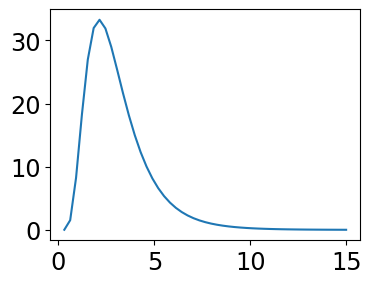

In [27]:
plt.plot(x,y)

In [28]:
x = np.linspace(-5,19)
y = pdf_normal(x,a0=100,mu=3,sigma=1)

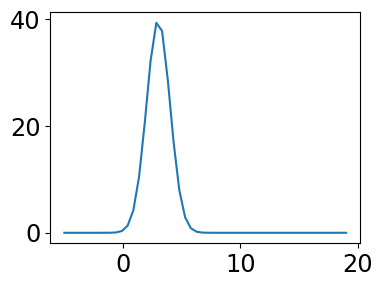

In [29]:
plt.plot(x,y)

## Configuration

In [30]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0

np.float64(3630.7805477010033)

In [31]:
observing_location = EarthLocation.of_site('Rubin Observatory')
tz = timezone('America/Santiago')

In [32]:
am0 = 1.20    # airmass
pwv0 = 4.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.0 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent


In [33]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

Text(0.5, 1.0, 'Standard atmosphere transmission')

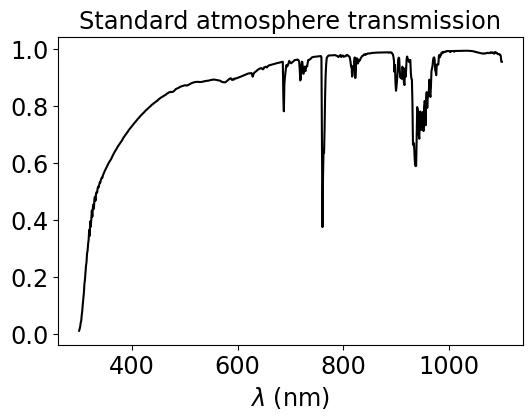

In [34]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Text(0.5, 1.0, 'Instrument throughput (LSST)')

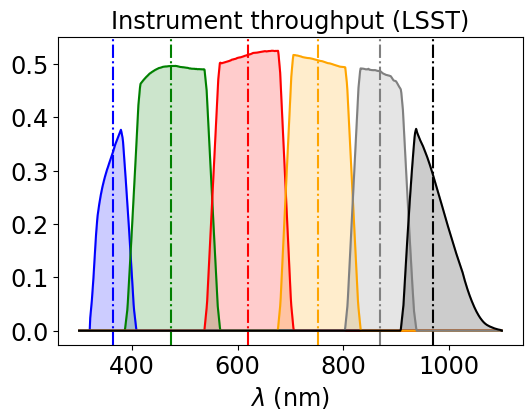

In [35]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (LSST)")


Text(0.5, 1.0, 'Total filter throughput (LSST)')

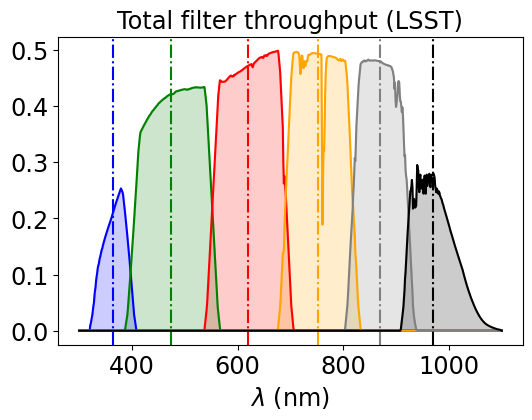

In [36]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (LSST)")


### MERRA2

In [37]:
filename_m2 = f"../data/{obs}/pwv/Merge_pwv_{obs}_inst1_2d_asm_Nx_M2I1NXASM-2017-2025.csv"
filename_m2b = f"../data/{obs}/aer/Merge_aer_{obs}_tavg1_2d_aer_Nx_M2T1NXAER-2017-2025.csv"

In [38]:
df_m = pd.read_csv(filename_m2)
df_mb = pd.read_csv(filename_m2b)

In [39]:
df_mb.columns

Index(['Unnamed: 0', 'time', 'TOTANGSTR', 'TOTEXTTAU', 'TOTSCATAU', 'Time'], dtype='object')

In [40]:
TMIN = pd.to_datetime(df_m.time.min())
TMAX = pd.to_datetime(df_m.time.max())

In [41]:
pd.to_datetime(df_m.Time.values)

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2025-01-31 14:00:00', '2025-01-31 15:00:00',
               '2025-01-31 16:00:00', '2025-01-31 17:00:00',
               '2025-01-31 18:00:00', '2025-01-31 19:00:00',
               '2025-01-31 20:00:00', '2025-01-31 21:00:00',
               '2025-01-31 22:00:00', '2025-01-31 23:00:00'],
              dtype='datetime64[ns]', length=67176, freq=None)

## Precipitable water vapor

- see the formula of log-normal on wikipedia

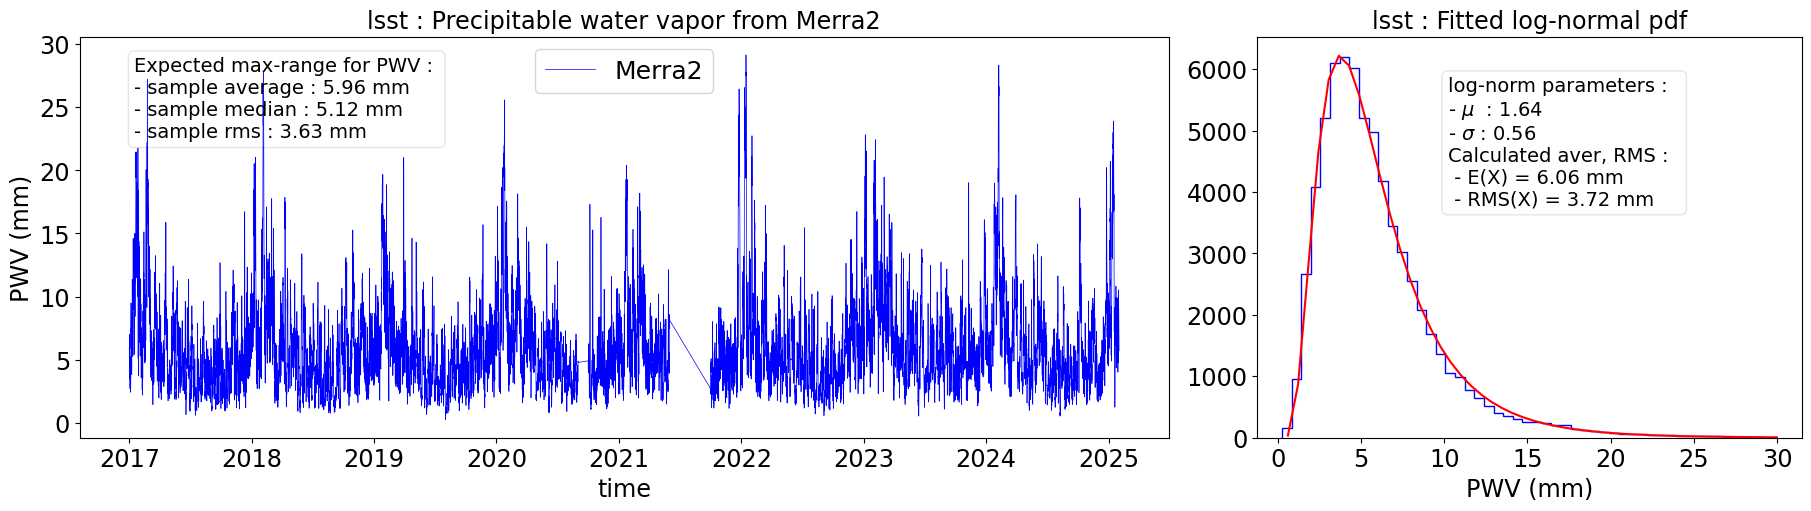

In [42]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%Y")

fig = plt.figure(figsize=(18,5),layout="constrained")
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_m.Time.values), df_m.TQV.values,c="b",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title(f"{obs} : Precipitable water vapor from Merra2")
ax1.legend()
ax1.set_ylabel("PWV (mm)")
#ax.set_xlim(TMIN,TMAX)

data = df_m.TQV.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected max-range for PWV : ",
                     f"- sample average : {mean:.2f} mm",
                     f"- sample median : {median:.2f} mm",
                     f"- sample rms : {std:.2f} mm",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)

XMIN = 0.
XMAX = 30.
counts,xedges, _ = ax2.hist(df_m.TQV.values,bins=50,histtype="step",color="b",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,1.,0.5])

#---
# formula here : https://en.wikipedia.org/wiki/Log-normal_distribution
E_X = np.exp(popt[1]+popt[2]**2/2)
#RMS_X = np.exp(popt[1]+popt[2]**2)
RMS_X =  np.sqrt((np.exp(2*popt[1]+popt[2]**2))*(np.exp(popt[2]**2)-1.))
#---

sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,50)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")
textstr2 = "\n".join((f"log-norm parameters : ",
                     "- ${\mu}$ " + f" : {popt[1]:.2f}",
                     "- $\sigma$" + f" : {popt[2]:.2f}",   
                     "Calculated aver, RMS :  ",
                     f" - E(X) = {E_X:.2f} mm",
                     f" - RMS(X) = {RMS_X:.2f} mm" 
                    ))
ax2.text(0.35, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("PWV (mm)")
ax2.set_title(f"{obs} : Fitted log-normal pdf")

figname =f"{pathfigs}/{obs}_pwv_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()


### Simulation of PWV

In [43]:
data_sim_pwv = np.random.lognormal(popt[1],popt[2],50000)

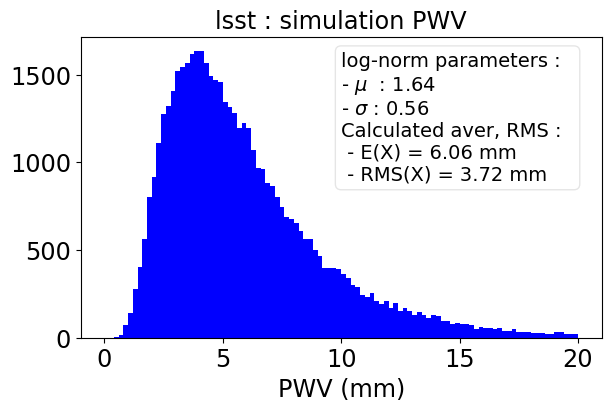

In [44]:
fig, ax = plt.subplots(1,1,figsize=(6,4),layout="constrained")
ax.hist(data_sim_pwv,bins=100,range=(0,20),facecolor="b");
ax.set_title(f"{obs} : simulation PWV")
ax.set_xlabel("PWV (mm)")
ax.text(0.5, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.show()

### Compute magnitudes Dispersion in bands

- Example in notebook : https://github.com/sylvielsstfr/RubinLSSTPhotometricCorrTuto/blob/23-ambre-library/notebooks/10_resolution/ComputeMagResolutionPWV_LSSTfilters.ipynb

In [45]:
am0 = 1.2
pwv0 = float(np.median(data_sim_pwv))
oz0 = 300.
tau0 = 0
beta0 = 1.

In [46]:
# select PWV
all_pwv = data_sim_pwv[data_sim_pwv<15.0]

In [47]:
NMAX = len(all_pwv)
NSAMP = 10000
a = np.arange(0,NMAX ,1)
b = np.random.choice(a, size=NSAMP,replace = False)
index_selected = np.sort(b)
all_pwv = all_pwv[index_selected] 

In [48]:
all_pwv

array([3.3144747 , 3.89466041, 2.31459153, ..., 3.95043983, 8.69216167,
       5.17427222], shape=(10000,))

In [49]:
pwv0

5.179304952691993

In [50]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc.CalculateMultiObs(am0,all_pwv,oz0,tau0,beta0)

In [51]:
the_sed_flat = Sed()
the_sed_flat.set_flat_sed()
the_sed_flat.name = 'flat'
zmag = 20.0
flux_norm = the_sed_flat.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
the_sed_flat.multiply_flux_norm(flux_norm)

In [52]:
mag_std = {}
adu_std = {}
atm_bands = pc.bandpass_total_std
for index,f in enumerate(filter_tagnames) :
    mag_std[f] = the_sed_flat.calc_mag(atm_bands[f])
    adu_std[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))

In [53]:
df = pd.DataFrame(columns = ["pwv","magu","magg","magr","magi","magz","magy",
                                   "aduu","adug","adur","adui","aduz","aduy"])

for idx_pwv,pwv in enumerate(all_pwv):
    mag_nonstd = {}
    adu_nonstd = {}
    atm_bands = pc.coll_bandpass_total_nonstd[idx_pwv] 
    for index,f in enumerate(filter_tagnames) :
        mag_nonstd[f] = the_sed_flat.calc_mag(atm_bands[f])
        adu_nonstd[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))
   
    df.loc[idx_pwv] = [pwv, mag_nonstd["u"],mag_nonstd["g"],mag_nonstd["r"],mag_nonstd["i"],mag_nonstd["z"],mag_nonstd["y"],
                       adu_nonstd["u"],adu_nonstd["g"],adu_nonstd["r"],adu_nonstd["i"],adu_nonstd["z"],adu_nonstd["y"]] 

df = df[["pwv","aduu","adug","adur","adui","aduz","aduy"]]

In [54]:
for index,f in enumerate(filter_tagnames) :
    label_in = f'adu{f}'
    label_out =f'd_adu{f}'
    df[label_out] = (df[label_in]- adu_std[f])*1000. 

In [55]:
df = df[["pwv","d_aduu","d_adug","d_adur","d_adui","d_aduz","d_aduy"]]

In [56]:
df.describe()

,pwv,d_aduu,d_adug,d_adur,d_adui,d_aduz,d_aduy
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.666575,7.284394e-06,0.011848,0.150161,0.939349,1.309047,2.914526
std,2.877719,3.957494e-05,0.069012,0.915320,6.943998,13.883579,52.888547
min,0.730341,-6.002290e-05,-0.105868,-1.440776,-12.030235,-27.372791,-121.673441
25%,3.507738,-2.143520e-05,-0.039877,-0.537822,-4.307656,-9.182313,-36.375833
50%,5.085087,-8.067014e-07,-0.002249,-0.030204,-0.237057,-0.491150,-1.889915
75%,7.256839,2.804382e-05,0.049757,0.662832,5.069162,10.145862,37.960494
max,14.997377,1.372263e-04,0.236849,3.081244,21.927691,40.189613,142.506565


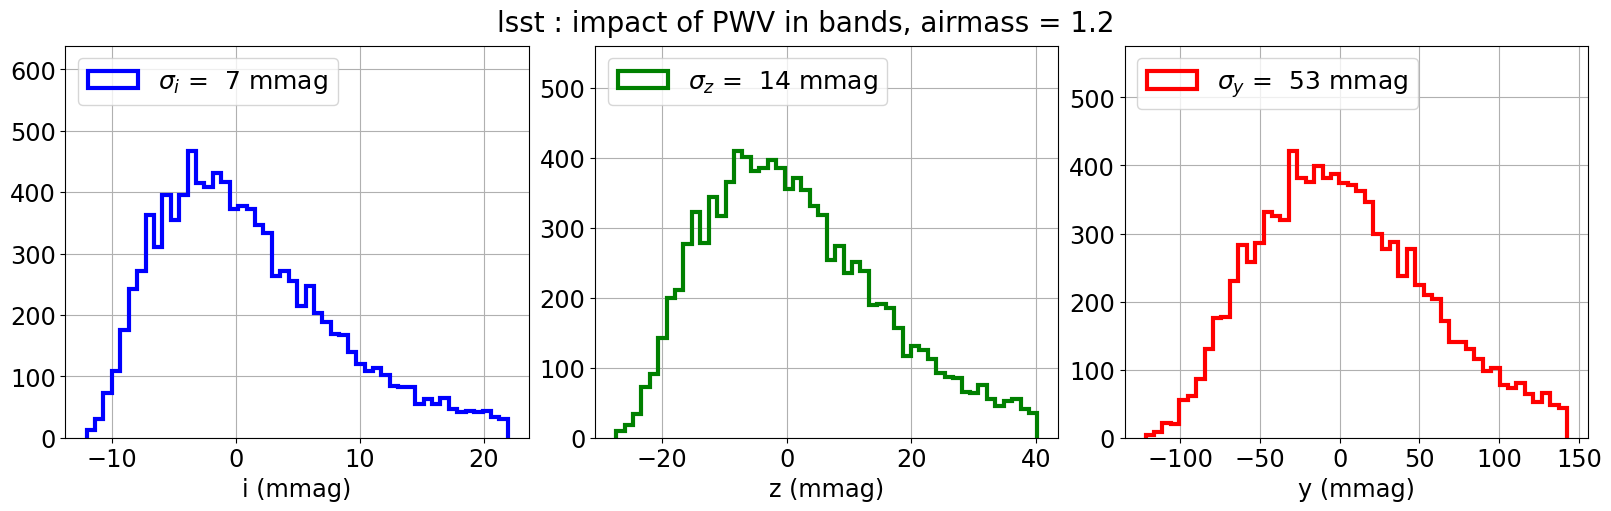

In [57]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_adui"].agg(["std"])["std"]
txt1 = "$\sigma_i$ = " +f" {std1:.0f} mmag"
std2 = df["d_aduz"].agg(["std"])["std"]
txt2 = "$\sigma_z$ = " +f" {std2:.0f} mmag"
std3 = df["d_aduy"].agg(["std"])["std"]
txt3 = "$\sigma_y$ = " +f" {std3:.0f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_adui"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_aduz"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_aduy"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("i (mmag)") ;  ax2.set_xlabel("z (mmag)") ; ax3.set_xlabel("y (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
plt.suptitle(f"{obs} : impact of PWV in bands, airmass = {am0}",fontsize=20)
plt.show()

In [58]:
df["d_R-I"] = df["d_adur"] -  df["d_adui"]
df["d_I-Z"] = df["d_adui"] -  df["d_aduz"]
df["d_Z-Y"] = df["d_aduz"] -  df["d_aduy"]

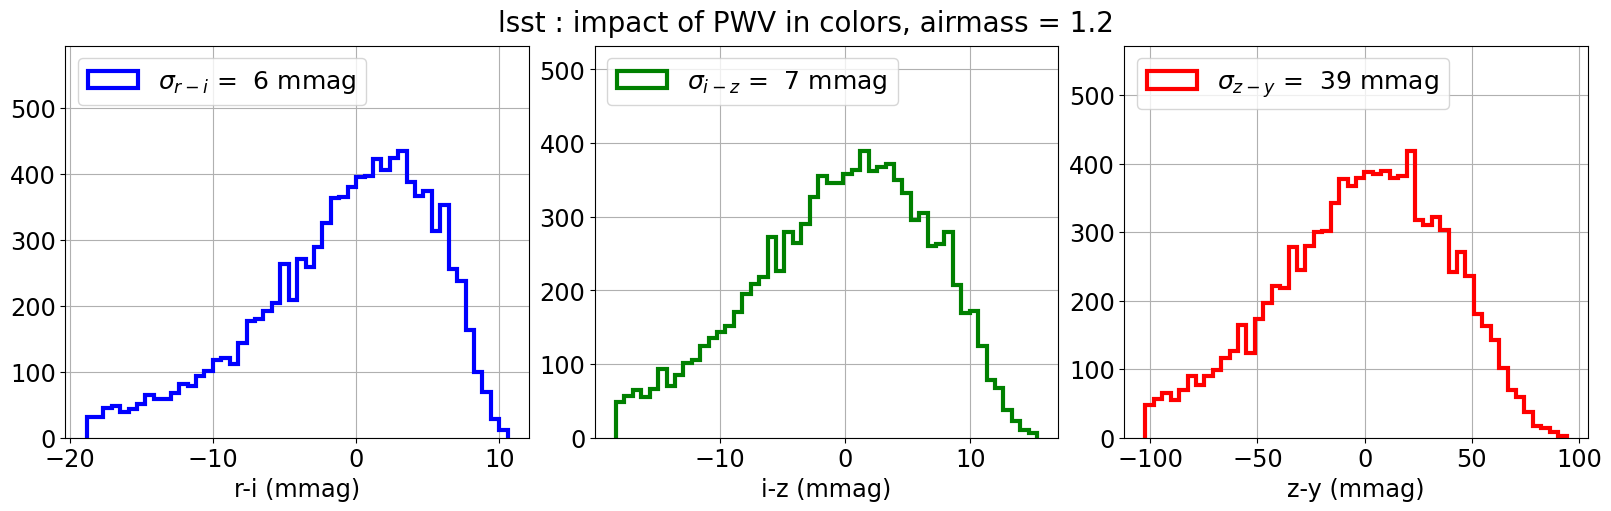

In [59]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_R-I"].agg(["std"])["std"]
txt1 = "$\sigma_{r-i}$ = " +f" {std1:.0f} mmag"
std2 = df["d_I-Z"].agg(["std"])["std"]
txt2 = "$\sigma_{i-z}$ = " +f" {std2:.0f} mmag"
std3 = df["d_Z-Y"].agg(["std"])["std"]
txt3 = "$\sigma_{z-y}$ = " +f" {std3:.0f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_R-I"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_I-Z"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_Z-Y"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("r-i (mmag)") ;  ax2.set_xlabel("i-z (mmag)") ; ax3.set_xlabel("z-y (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
plt.suptitle(f"{obs} : impact of PWV in colors, airmass = {am0}",fontsize=20)
plt.show()

## Ozone

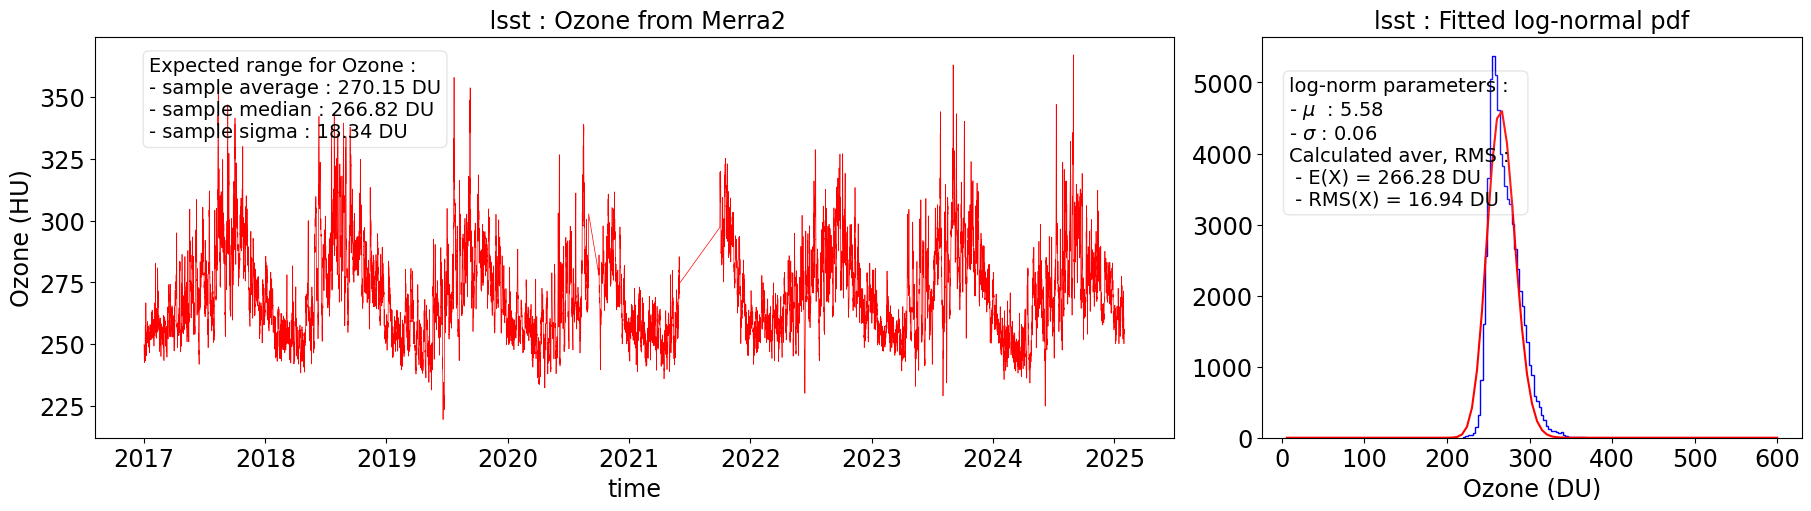

In [60]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%Y")

fig = plt.figure(figsize=(18,5),layout="constrained")
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_m.Time.values), df_m.TO3.values,c="r",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title(f" {obs} : Ozone from Merra2")
#ax1.legend()
ax1.set_ylabel("Ozone (HU)")
#ax.set_xlim(TMIN,TMAX)

data = df_m.TO3.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected range for Ozone : ",
                     f"- sample average : {mean:.2f} DU",
                     f"- sample median : {median:.2f} DU",
                     f"- sample sigma : {std:.2f} DU",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)




XMIN = 0.
XMAX = 600.
counts,xedges, _ = ax2.hist(df_m.TO3.values,bins=50,histtype="step",color="b",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,300.,100])
#popt, pcov = curve_fit(pdf_normal, xdata, ydata, p0 = [1000.,300.,10])

#---
# formula here : https://en.wikipedia.org/wiki/Log-normal_distribution
E_X = np.exp(popt[1]+popt[2]**2/2)
#RMS_X = np.exp(popt[1]+popt[2]**2)
RMS_X =  np.sqrt((np.exp(2*popt[1]+popt[2]**2))*(np.exp(popt[2]**2)-1.))
#---
#E_X =popt[1]
#RMS_X = popt[2]

sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,100)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")

textstr2 = "\n".join((f"log-norm parameters : ",
                     "- ${\mu}$ " + f" : {popt[1]:.2f}",
                     "- $\sigma$" + f" : {popt[2]:.2f}",   
                     "Calculated aver, RMS :  ",
                     f" - E(X) = {E_X:.2f} DU",
                     f" - RMS(X) = {RMS_X:.2f} DU" 
                    ))

ax2.text(0.05, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("Ozone (DU)")
ax2.set_title(f"{obs} : Fitted log-normal pdf")


figname =f"{pathfigs}/{obs}_ozone_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()


### Simulation of Ozone

In [61]:
data_sim_o3 = np.random.lognormal(popt[1],popt[2],50000)

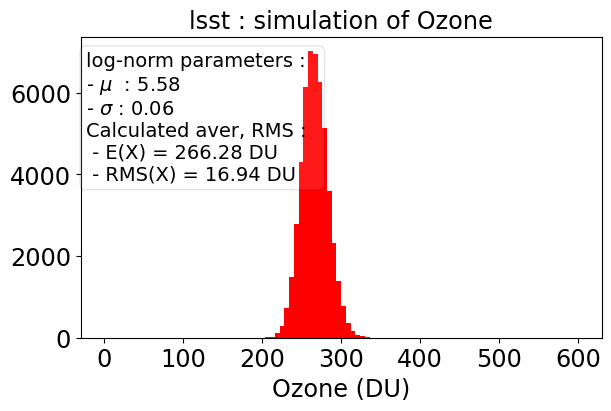

In [62]:
fig, ax = plt.subplots(1,1,figsize=(6,4),layout="constrained")
ax.hist(data_sim_o3,bins=100,range=(0,600),facecolor="r");
ax.set_title(f"{obs} : simulation of Ozone")
ax.set_xlabel("Ozone (DU)")
ax.text(0.01, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.show()

### Compute magnitudes Dispersion in bands

- Example in notebook : https://github.com/sylvielsstfr/RubinLSSTPhotometricCorrTuto/blob/23-ambre-library/notebooks/10_resolution/ComputeMagResolutionPWV_LSSTfilters.ipynb

In [63]:
am0 = 1.2
pwv0 = 5.
oz0 = np.median(data_sim_o3)
tau0 = 0
beta0 = 1.

In [64]:
all_ozone = data_sim_o3[data_sim_o3<600]

In [65]:
NMAX = len(all_ozone)
NSAMP = 10000
a = np.arange(0,NMAX ,1)
b = np.random.choice(a, size=NSAMP,replace = False)
index_selected = np.sort(b)
all_ozone = all_ozone[index_selected] 

In [66]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc.CalculateMultiObs(am0,pwv0,all_ozone,tau0,beta0)

In [67]:
mag_std = {}
adu_std = {}
atm_bands = pc.bandpass_total_std
for index,f in enumerate(filter_tagnames) :
    mag_std[f] = the_sed_flat.calc_mag(atm_bands[f])
    adu_std[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))

In [68]:
df = pd.DataFrame(columns = ["oz","magu","magg","magr","magi","magz","magy",
                                   "aduu","adug","adur","adui","aduz","aduy"])

for idx_oz,oz in enumerate(all_ozone):
    mag_nonstd = {}
    adu_nonstd = {}
    atm_bands = pc.coll_bandpass_total_nonstd[idx_oz] 
    for index,f in enumerate(filter_tagnames) :
        mag_nonstd[f] = the_sed_flat.calc_mag(atm_bands[f])
        adu_nonstd[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))
   
    df.loc[idx_oz] = [oz, mag_nonstd["u"],mag_nonstd["g"],mag_nonstd["r"],mag_nonstd["i"],mag_nonstd["z"],mag_nonstd["y"],
                       adu_nonstd["u"],adu_nonstd["g"],adu_nonstd["r"],adu_nonstd["i"],adu_nonstd["z"],adu_nonstd["y"]] 

df = df[["oz","aduu","adug","adur","adui","aduz","aduy"]]

In [69]:
for index,f in enumerate(filter_tagnames) :
    label_in = f'adu{f}'
    label_out =f'd_adu{f}'
    df[label_out] = (df[label_in]- adu_std[f])*1000. 

In [70]:
df = df[["oz","d_aduu","d_adug","d_adur","d_adui","d_aduz","d_aduy"]]

In [71]:
df.describe()

,oz,d_aduu,d_adug,d_adur,d_adui,d_aduz,d_aduy
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0
mean,266.299921,0.009002,0.018918,0.065349,0.009004,0.000970,0.0
std,17.039557,0.287086,0.579572,1.987501,0.274231,0.029520,0.0
min,209.619324,-0.951555,-1.910868,-6.548844,-0.903338,-0.097223,0.0
25%,254.529309,-0.189090,-0.381360,-1.307406,-0.180425,-0.019424,0.0
50%,265.585798,-0.002603,-0.005251,-0.018008,-0.002484,-0.000267,0.0
75%,277.518216,0.198455,0.400660,1.374364,0.189566,0.020406,0.0
max,345.987845,1.341505,2.725998,9.355434,1.291239,0.138998,0.0


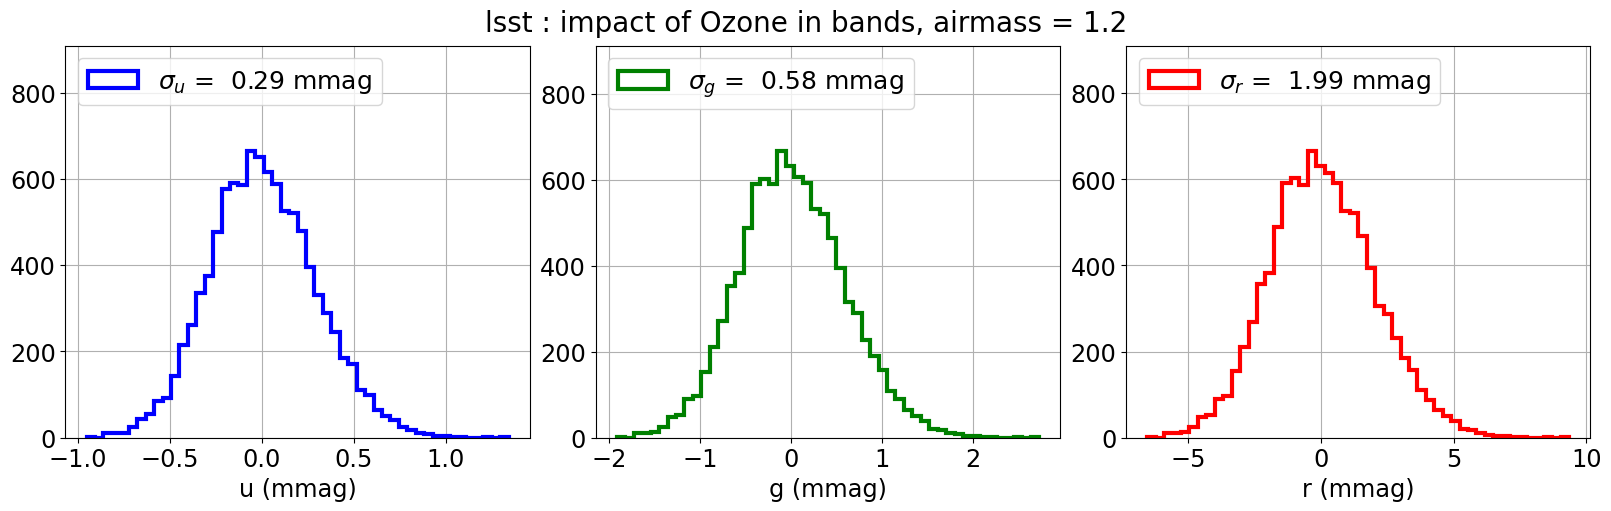

In [72]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_aduu"].agg(["std"])["std"]
txt1 = "$\sigma_u$ = " +f" {std1:.2f} mmag"
std2 = df["d_adug"].agg(["std"])["std"]
txt2 = "$\sigma_g$ = " +f" {std2:.2f} mmag"
std3 = df["d_adur"].agg(["std"])["std"]
txt3 = "$\sigma_r$ = " +f" {std3:.2f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_aduu"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_adug"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_adur"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("u (mmag)") ;  ax2.set_xlabel("g (mmag)") ; ax3.set_xlabel("r (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
plt.suptitle(f"{obs} : impact of Ozone in bands, airmass = {am0}",fontsize=20)
plt.show()

In [73]:
df["d_U-G"] = df["d_aduu"] -  df["d_adug"]
df["d_G-R"] = df["d_adug"] -  df["d_adur"]
df["d_R-I"] = df["d_adur"] -  df["d_adui"]

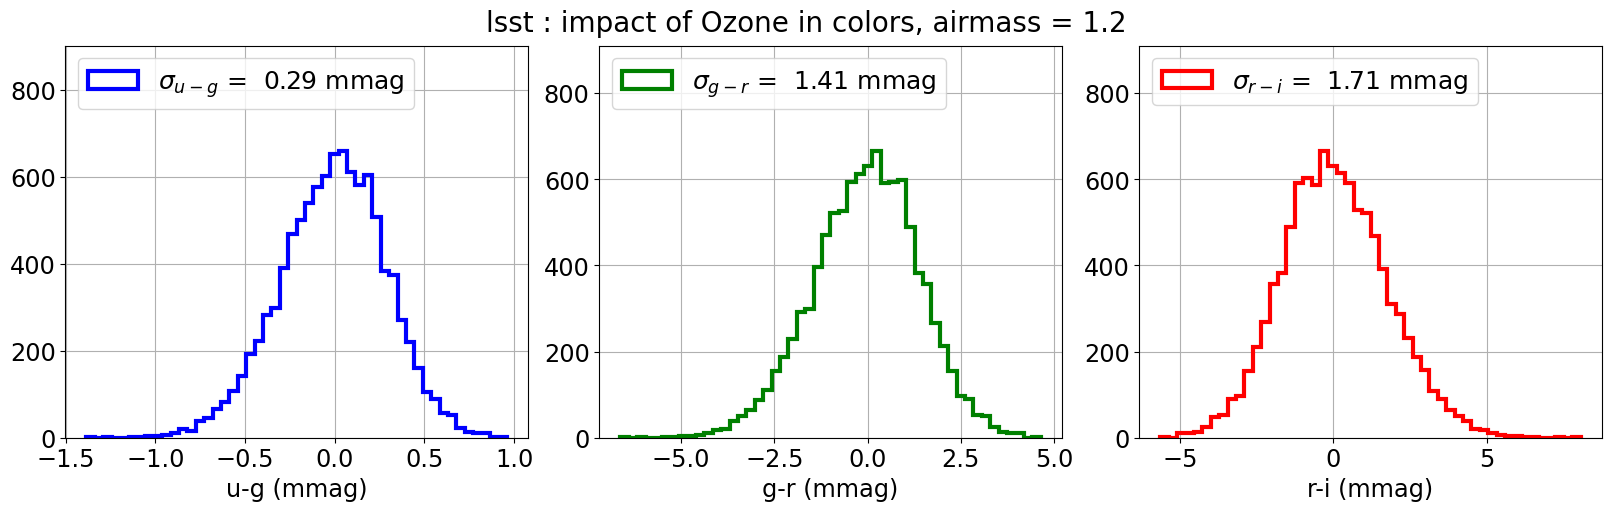

In [74]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_U-G"].agg(["std"])["std"]
txt1 = "$\sigma_{u-g}$ = " +f" {std1:.2f} mmag"
std2 = df["d_G-R"].agg(["std"])["std"]
txt2 = "$\sigma_{g-r}$ = " +f" {std2:.2f} mmag"
std3 = df["d_R-I"].agg(["std"])["std"]
txt3 = "$\sigma_{r-i}$ = " +f" {std3:.2f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_U-G"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_G-R"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_R-I"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("u-g (mmag)") ;  ax2.set_xlabel("g-r (mmag)") ; ax3.set_xlabel("r-i (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
plt.suptitle(f"{obs} : impact of Ozone in colors, airmass = {am0}",fontsize=20)
plt.show()

## Aerosols : VAOD

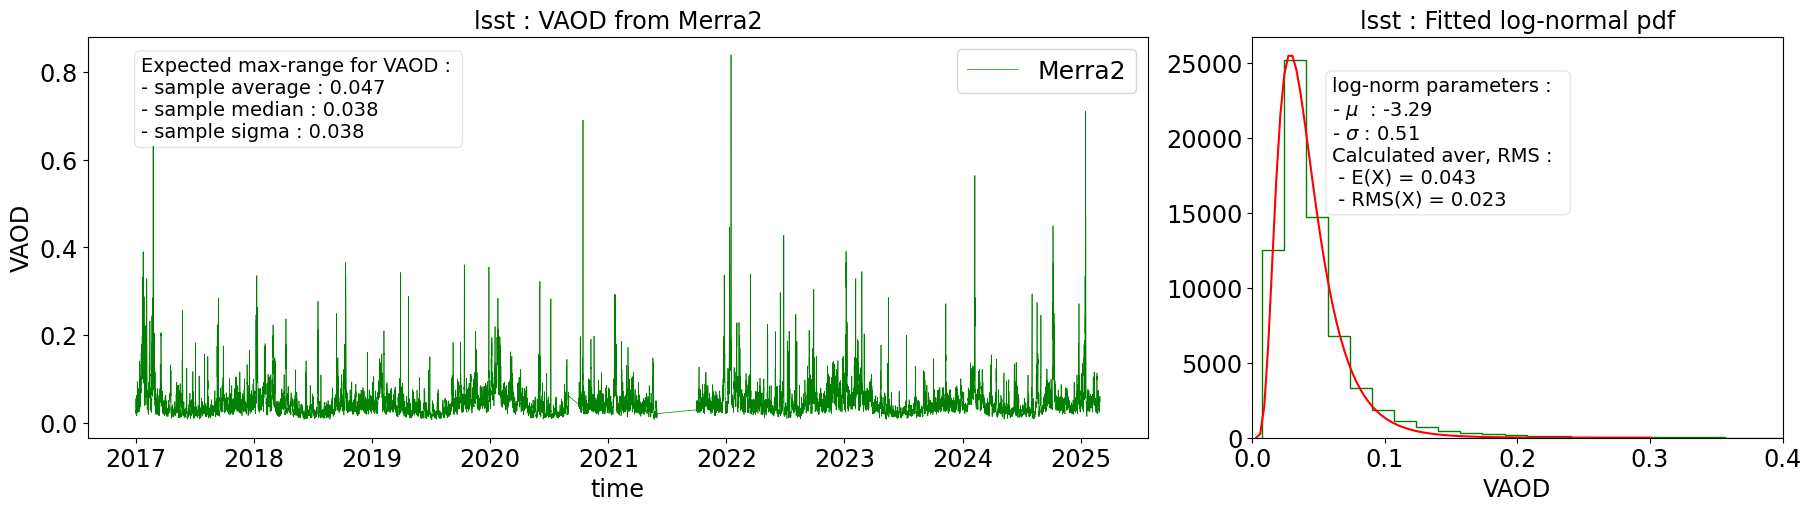

In [75]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%Y")

fig = plt.figure(figsize=(18,5),layout="constrained")
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_mb.Time.values), df_mb.TOTEXTTAU.values,c="g",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title(f"{obs} : VAOD from Merra2")
ax1.legend()
ax1.set_ylabel("VAOD")
#ax.set_xlim(TMIN,TMAX)
data = df_mb.TOTEXTTAU.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected max-range for VAOD : ",
                     f"- sample average : {mean:.3f}",
                     f"- sample median : {median:.3f}",
                     f"- sample sigma : {std:.3f}",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)


XMIN = 0.
XMAX = 0.3
counts,xedges, _ = ax2.hist(df_mb.TOTEXTTAU.values,bins=50,histtype="step",color="g",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,1.,0.5])

#---
# formula here : https://en.wikipedia.org/wiki/Log-normal_distribution
E_X = np.exp(popt[1]+popt[2]**2/2)
#RMS_X = np.exp(popt[1]+popt[2]**2)
RMS_X =  np.sqrt((np.exp(2*popt[1]+popt[2]**2))*(np.exp(popt[2]**2)-1.))
#---


sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,100)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")
ax2.set_xlim(0.,0.4)

textstr2 = "\n".join((f"log-norm parameters : ",
                     "- ${\mu}$ " + f" : {popt[1]:.2f}",
                     "- $\sigma$" + f" : {popt[2]:.2f}",   
                     "Calculated aver, RMS :  ",
                     f" - E(X) = {E_X:.3f} ",
                     f" - RMS(X) = {RMS_X:.3f}" 
                    ))


ax2.text(0.15, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("VAOD")
ax2.set_title(f"{obs} : Fitted log-normal pdf")


figname =f"{pathfigs}/{obs}_vaod_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()


### Simulation of Aerosols - VAOD

In [76]:
data_sim_vaod = np.random.lognormal(popt[1],popt[2],50000)

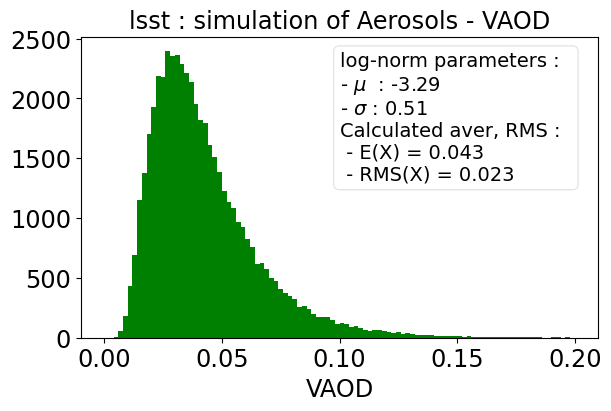

In [77]:
fig, ax = plt.subplots(1,1,figsize=(6,4),layout="constrained")
ax.hist(data_sim_vaod,bins=100,range=(0.,0.2),facecolor="g");
ax.set_title(f"{obs} : simulation of Aerosols - VAOD")
ax.set_xlabel("VAOD")
ax.text(0.5, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.show()

### Compute magnitudes Dispersion in bands

- Example in notebook : https://github.com/sylvielsstfr/RubinLSSTPhotometricCorrTuto/blob/23-ambre-library/notebooks/10_resolution/ComputeMagResolutionPWV_LSSTfilters.ipynb

In [78]:
am0 = 1.2
pwv0 = 5.
oz0 = 300.
tau0 = np.median(data_sim_vaod) 
beta0 = 1.4

In [79]:
all_taus = data_sim_vaod

In [80]:
NMAX = len(all_taus)
NSAMP = 10000
a = np.arange(0,NMAX ,1)
b = np.random.choice(a, size=NSAMP,replace = False)
index_selected = np.sort(b)
all_taus = all_taus[index_selected] 

In [81]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc.CalculateMultiObs(am0,pwv0,oz0,all_taus,beta0)

In [82]:
mag_std = {}
adu_std = {}
atm_bands = pc.bandpass_total_std
for index,f in enumerate(filter_tagnames) :
    mag_std[f] = the_sed_flat.calc_mag(atm_bands[f])
    adu_std[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))

In [83]:
df = pd.DataFrame(columns = ["tau","magu","magg","magr","magi","magz","magy",
                                   "aduu","adug","adur","adui","aduz","aduy"])

for idx_tau,tau in enumerate(all_taus):
    mag_nonstd = {}
    adu_nonstd = {}
    atm_bands = pc.coll_bandpass_total_nonstd[idx_tau] 
    for index,f in enumerate(filter_tagnames) :
        mag_nonstd[f] = the_sed_flat.calc_mag(atm_bands[f])
        adu_nonstd[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))
   
    df.loc[idx_tau] = [tau, mag_nonstd["u"],mag_nonstd["g"],mag_nonstd["r"],mag_nonstd["i"],mag_nonstd["z"],mag_nonstd["y"],
                       adu_nonstd["u"],adu_nonstd["g"],adu_nonstd["r"],adu_nonstd["i"],adu_nonstd["z"],adu_nonstd["y"]] 

df = df[["tau","aduu","adug","adur","adui","aduz","aduy"]]

In [84]:
for index,f in enumerate(filter_tagnames) :
    label_in = f'adu{f}'
    label_out =f'd_adu{f}'
    df[label_out] = (df[label_in]- adu_std[f])*1000. 

In [85]:
df = df[["tau","d_aduu","d_adug","d_adur","d_adui","d_aduz","d_aduy"]]

In [86]:
df.describe()

,tau,d_aduu,d_adug,d_adur,d_adui,d_aduz,d_aduy
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.042584,10.494860,7.324270,5.025599,3.826680,3.126011,2.665517
std,0.023439,47.476759,33.143876,22.733041,17.307710,14.137874,12.055158
min,0.004201,-67.277531,-46.990110,-32.210046,-24.518294,-20.026106,-17.075834
25%,0.026537,-22.013532,-15.373480,-10.539621,-8.023148,-6.553310,-5.587879
50%,0.037352,-0.099527,-0.069502,-0.047652,-0.036275,-0.029630,-0.025265
75%,0.052654,30.902706,21.578234,14.796127,11.263993,9.200671,7.845250
max,0.355641,643.717081,448.729056,308.341866,234.887732,191.918961,163.650251


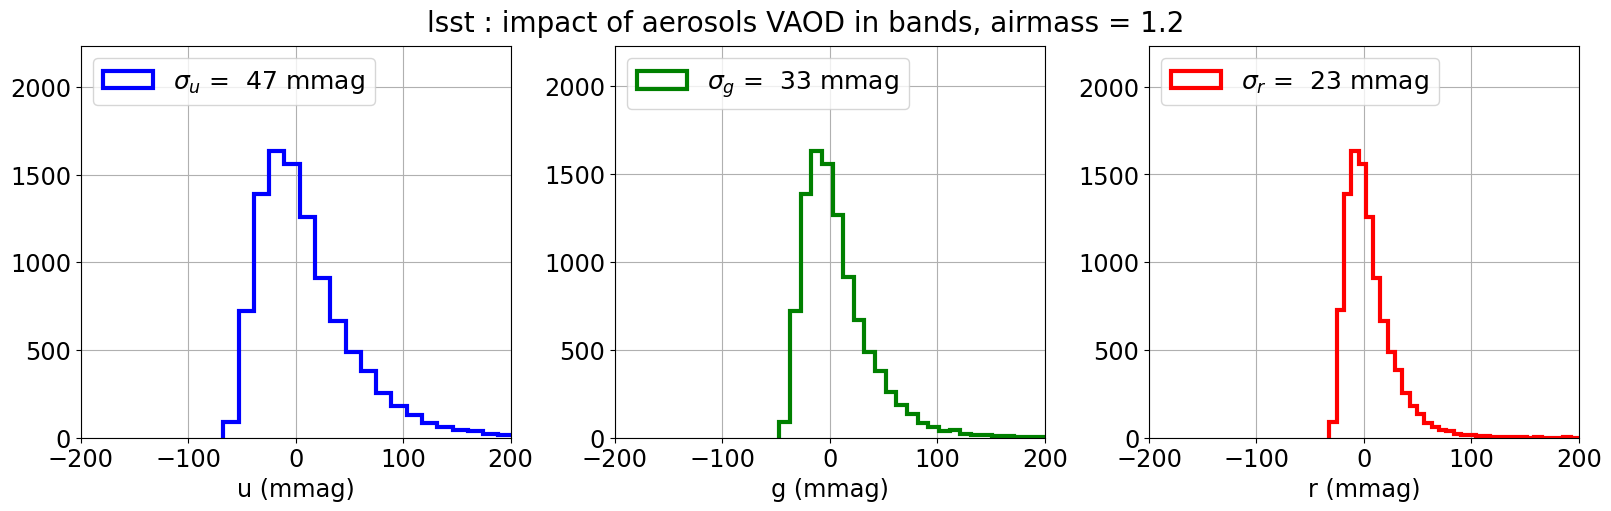

In [87]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_aduu"].agg(["std"])["std"]
txt1 = "$\sigma_u$ = " +f" {std1:.0f} mmag"
std2 = df["d_adug"].agg(["std"])["std"]
txt2 = "$\sigma_g$ = " +f" {std2:.0f} mmag"
std3 = df["d_adur"].agg(["std"])["std"]
txt3 = "$\sigma_r$ = " +f" {std3:.0f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_aduu"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_adug"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_adur"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("u (mmag)") ;  ax2.set_xlabel("g (mmag)") ; ax3.set_xlabel("r (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
ax1.set_xlim(-200,200.); ax2.set_xlim(-200,200.); ax3.set_xlim(-200,200.); 
plt.suptitle(f"{obs} : impact of aerosols VAOD in bands, airmass = {am0}",fontsize=20)
plt.show()

In [88]:
df["d_U-G"] = df["d_aduu"] -  df["d_adug"]
df["d_G-R"] = df["d_adug"] -  df["d_adur"]
df["d_R-I"] = df["d_adur"] -  df["d_adui"]

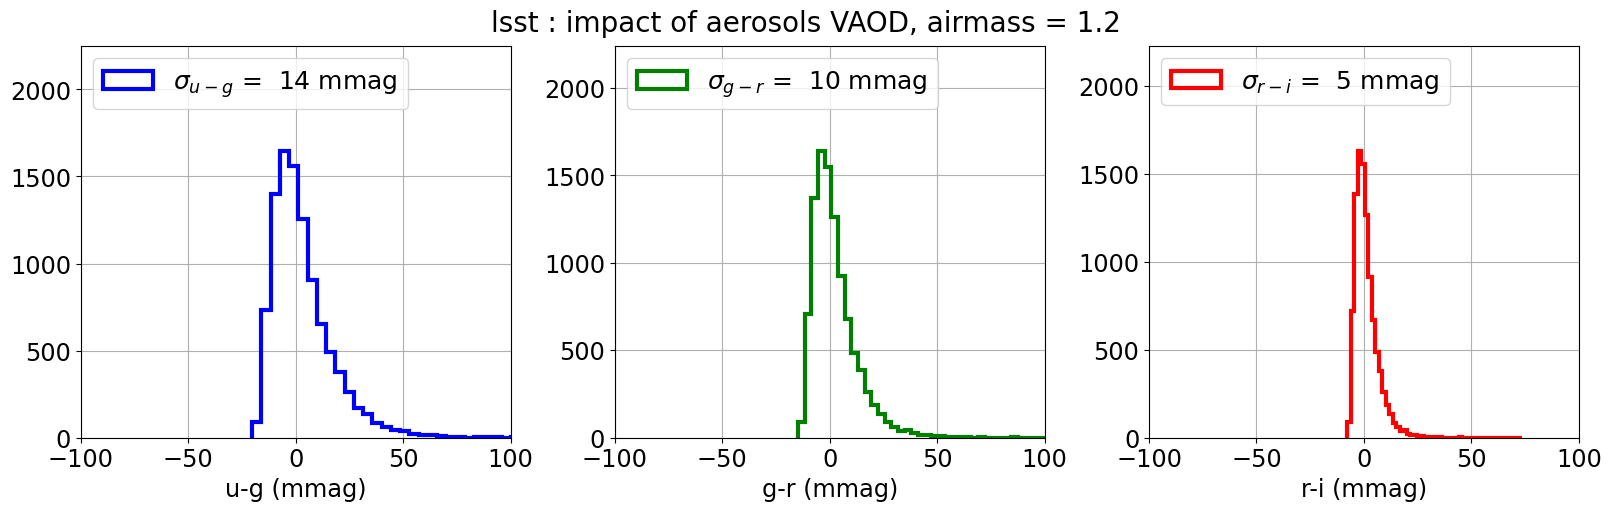

In [89]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_U-G"].agg(["std"])["std"]
txt1 = "$\sigma_{u-g}$ = " +f" {std1:.0f} mmag"
std2 = df["d_G-R"].agg(["std"])["std"]
txt2 = "$\sigma_{g-r}$ = " +f" {std2:.0f} mmag"
std3 = df["d_R-I"].agg(["std"])["std"]
txt3 = "$\sigma_{r-i}$ = " +f" {std3:.0f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_U-G"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_G-R"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_R-I"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("u-g (mmag)") ;  ax2.set_xlabel("g-r (mmag)") ; ax3.set_xlabel("r-i (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
ax1.set_xlim(-100,100.); ax2.set_xlim(-100,100.); ax3.set_xlim(-100,100.); 
plt.suptitle(f"{obs} : impact of aerosols VAOD, airmass = {am0}",fontsize=20)
plt.show()

## Aerosols - Angstrom Exponent

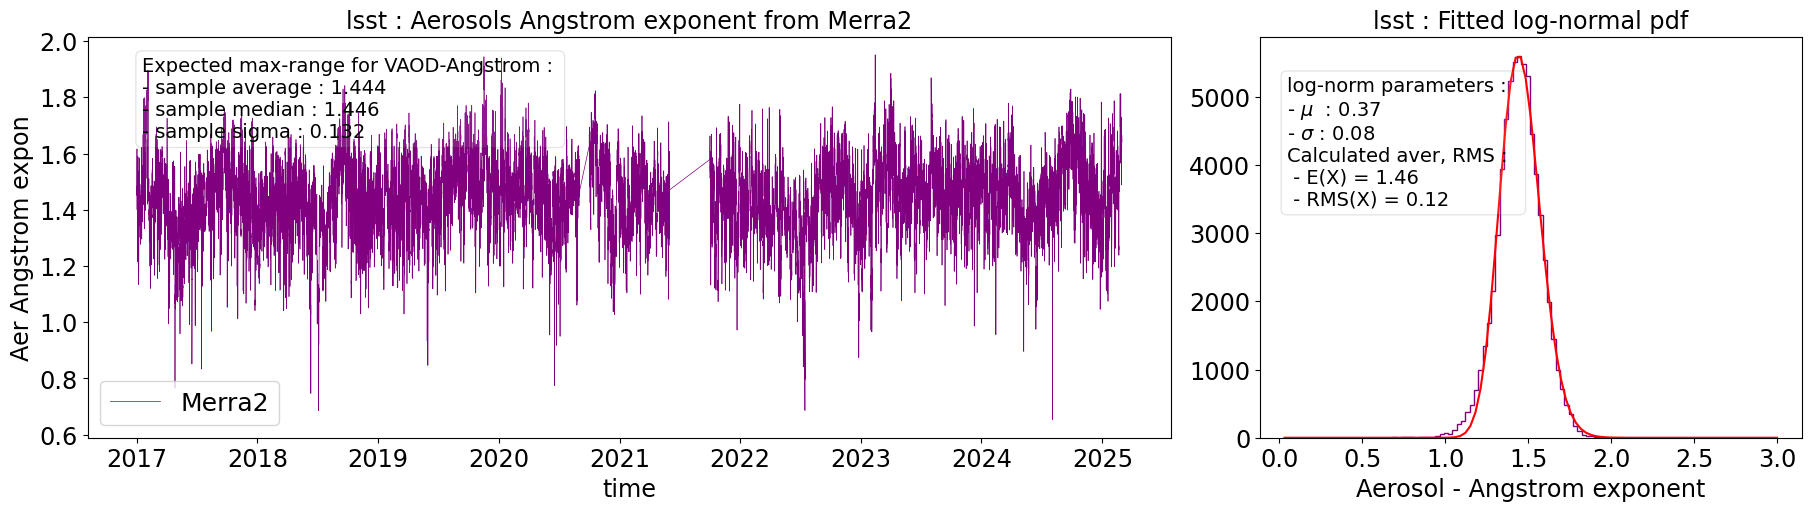

In [90]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%Y")

fig = plt.figure(figsize=(18,5),layout="constrained")
gs = GridSpec(1, 2,  width_ratios=[2,1],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.plot(pd.to_datetime(df_mb.Time.values), df_mb.TOTANGSTR.values,c="purple",lw=0.5,label="Merra2")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title(f"{obs} : Aerosols Angstrom exponent from Merra2")
ax1.legend()
ax1.set_ylabel("Aer Angstrom expon")
#ax.set_xlim(TMIN,TMAX)
data = df_mb.TOTANGSTR.values
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
textstr = "\n".join((f"Expected max-range for VAOD-Angstrom : ",
                     f"- sample average : {mean:.3f}",
                     f"- sample median : {median:.3f}",
                     f"- sample sigma : {std:.3f}",     
                    ))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)



XMIN = 0.
XMAX = 3.
counts,xedges, _ = ax2.hist(df_mb.TOTANGSTR.values,bins=50,histtype="step",color="purple",ls="-",lw=3)
xcenters = (xedges[:-1] + xedges[1:]) / 2

xdata = xcenters
ydata = counts

popt, pcov = curve_fit(pdf_lognormal, xdata, ydata, p0 = [100.,1.,0.5])

#---
# formula here : https://en.wikipedia.org/wiki/Log-normal_distribution
E_X = np.exp(popt[1]+popt[2]**2/2)
#RMS_X = np.exp(popt[1]+popt[2]**2)
RMS_X =  np.sqrt((np.exp(2*popt[1]+popt[2]**2))*(np.exp(popt[2]**2)-1.))
#---

sigmas = np.diag(pcov)
xfit = np.linspace(XMIN,XMAX,100)
yfit = pdf_lognormal(xfit,*popt)
ax2.plot(xfit,yfit,"-r")

textstr2 = "\n".join((f"log-norm parameters : ",
                     "- ${\mu}$ " + f" : {popt[1]:.2f}",
                     "- $\sigma$" + f" : {popt[2]:.2f}",   
                     "Calculated aver, RMS :  ",
                     f" - E(X) = {E_X:.2f} ",
                     f" - RMS(X) = {RMS_X:.2f}" 
                    ))


ax2.text(0.05, 0.9, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.set_xlabel("Aerosol - Angstrom exponent")
ax2.set_title(f"{obs} : Fitted log-normal pdf")


figname =f"{pathfigs}/{obs}_vaodangstrom_allpoints_merra2"+figtype
fig.savefig(figname)
plt.show()

### Simulation of Aerosol -Angstrom

In [91]:
data_sim_angstrom = np.random.lognormal(popt[1],popt[2],50000)

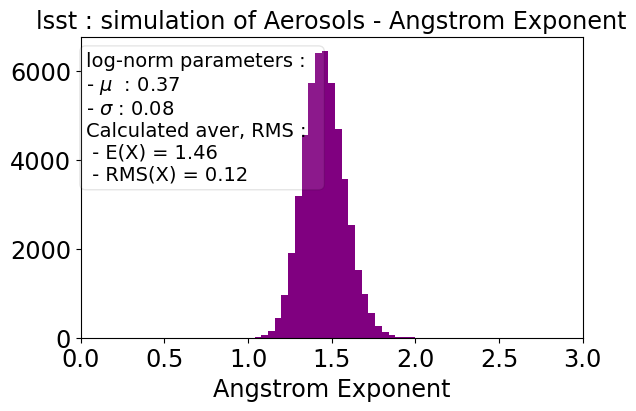

In [92]:
fig, ax = plt.subplots(1,1,figsize=(6,4),layout="constrained")
ax.hist(data_sim_angstrom,bins=100,range=(0.,4.),facecolor="purple");
ax.set_title(f"{obs} : simulation of Aerosols - Angstrom Exponent")
ax.set_xlabel("Angstrom Exponent")
ax.set_xlim(0.,3.)
ax.text(0.01, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.show()

### Compute magnitudes Dispersion in bands

- Example in notebook : https://github.com/sylvielsstfr/RubinLSSTPhotometricCorrTuto/blob/23-ambre-library/notebooks/10_resolution/ComputeMagResolutionPWV_LSSTfilters.ipynb

In [93]:
am0 = 1.2
pwv0 = 5.
oz0 = 300.
tau0 = np.median(data_sim_vaod) 
beta0 = np.median(data_sim_angstrom)

In [94]:
all_betas = data_sim_angstrom

In [95]:
NMAX = len(all_betas)
NSAMP = 10000
a = np.arange(0,NMAX ,1)
b = np.random.choice(a, size=NSAMP,replace = False)
index_selected = np.sort(b)
all_betas = all_betas[index_selected] 
#all_betas = np.random.random(size=NSAMP)*4.0+ 0.001
#all_betas = np.random.random(NSAMP)*4.0

In [96]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc.CalculateMultiObs(am0,pwv0,oz0,tau0,all_betas)

In [97]:
mag_std = {}
adu_std = {}
atm_bands = pc.bandpass_total_std
for index,f in enumerate(filter_tagnames) :
    mag_std[f] = the_sed_flat.calc_mag(atm_bands[f])
    adu_std[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))

In [98]:
df = pd.DataFrame(columns = ["beta","magu","magg","magr","magi","magz","magy",
                                   "aduu","adug","adur","adui","aduz","aduy"])

for idx_beta,beta in enumerate(all_betas):
    mag_nonstd = {}
    adu_nonstd = {}
    atm_bands = pc.coll_bandpass_total_nonstd[idx_beta] 
    for index,f in enumerate(filter_tagnames) :
        mag_nonstd[f] = the_sed_flat.calc_mag(atm_bands[f])
        adu_nonstd[f] = -2.5*np.log10(the_sed_flat.calc_adu(atm_bands[f],photoparams))
   
    df.loc[idx_beta] = [beta, mag_nonstd["u"],mag_nonstd["g"],mag_nonstd["r"],mag_nonstd["i"],mag_nonstd["z"],mag_nonstd["y"],
                       adu_nonstd["u"],adu_nonstd["g"],adu_nonstd["r"],adu_nonstd["i"],adu_nonstd["z"],adu_nonstd["y"]] 

df = df[["beta","aduu","adug","adur","adui","aduz","aduy"]]

In [99]:
for index,f in enumerate(filter_tagnames) :
    label_in = f'adu{f}'
    label_out =f'd_adu{f}'
    df[label_out] = (df[label_in]- adu_std[f])*1000. 

In [100]:
df = df[["beta","d_aduu","d_adug","d_adur","d_adui","d_aduz","d_aduy"]]

In [101]:
df.describe()

,beta,d_aduu,d_adug,d_adur,d_adui,d_aduz,d_aduy
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.455298,0.200596,0.024693,-0.029520,-0.028231,-0.018234,-0.008100
std,0.123627,3.046010,0.429657,0.917110,1.342250,1.478776,1.512575
min,0.968847,-10.878550,-1.590778,-3.925538,-5.480691,-5.820761,-5.781881
25%,1.370298,-1.913370,-0.272408,-0.650019,-0.946067,-1.037251,-1.056490
50%,1.449641,0.001140,0.000161,-0.000347,-0.000510,-0.000562,-0.000576
75%,1.537740,2.185608,0.307575,0.596031,0.880786,0.977184,1.004801
max,2.010956,15.053792,2.047182,3.785165,5.807400,6.636874,6.990686


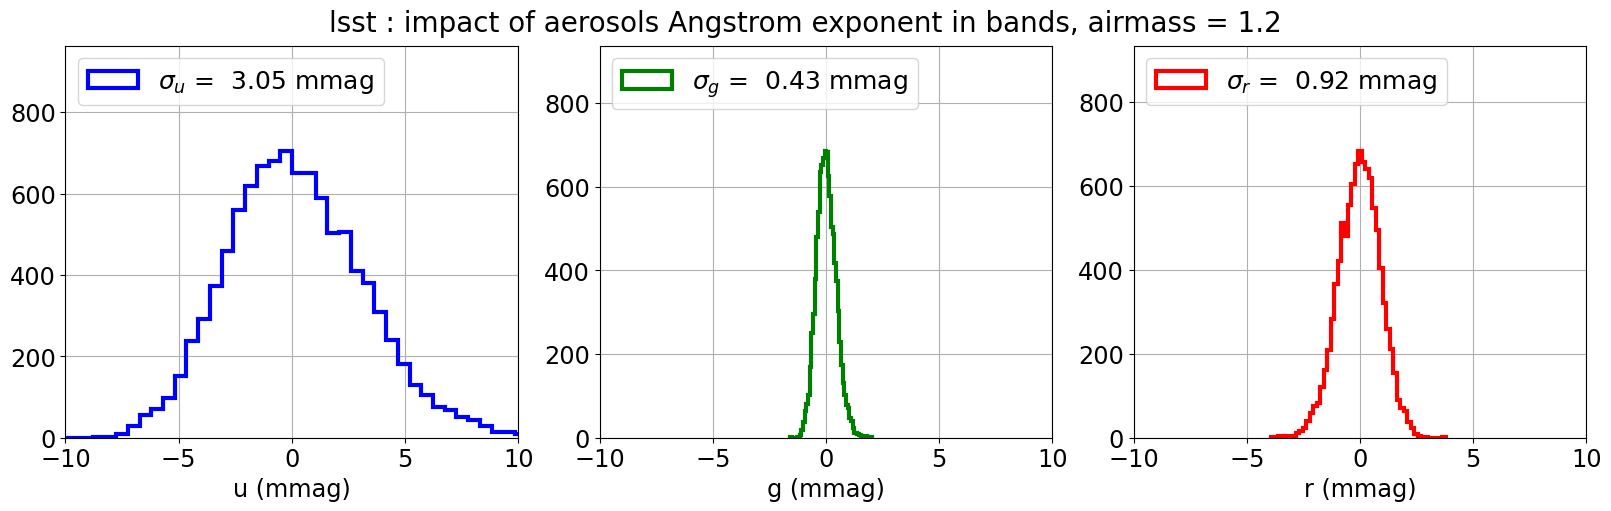

In [102]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_aduu"].agg(["std"])["std"]
txt1 = "$\sigma_u$ = " +f" {std1:.2f} mmag"
std2 = df["d_adug"].agg(["std"])["std"]
txt2 = "$\sigma_g$ = " +f" {std2:.2f} mmag"
std3 = df["d_adur"].agg(["std"])["std"]
txt3 = "$\sigma_r$ = " +f" {std3:.2f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_aduu"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_adug"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_adur"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("u (mmag)") ;  ax2.set_xlabel("g (mmag)") ; ax3.set_xlabel("r (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1]) 
ax1.set_xlim(-10,10.); ax2.set_xlim(-10,10.); ax3.set_xlim(-10,10.); 
plt.suptitle(f"{obs} : impact of aerosols Angstrom exponent in bands, airmass = {am0}",fontsize=20)
plt.show()

In [103]:
df["d_U-G"] = df["d_aduu"] -  df["d_adug"]
df["d_G-R"] = df["d_adug"] -  df["d_adur"]
df["d_R-I"] = df["d_adur"] -  df["d_adui"]

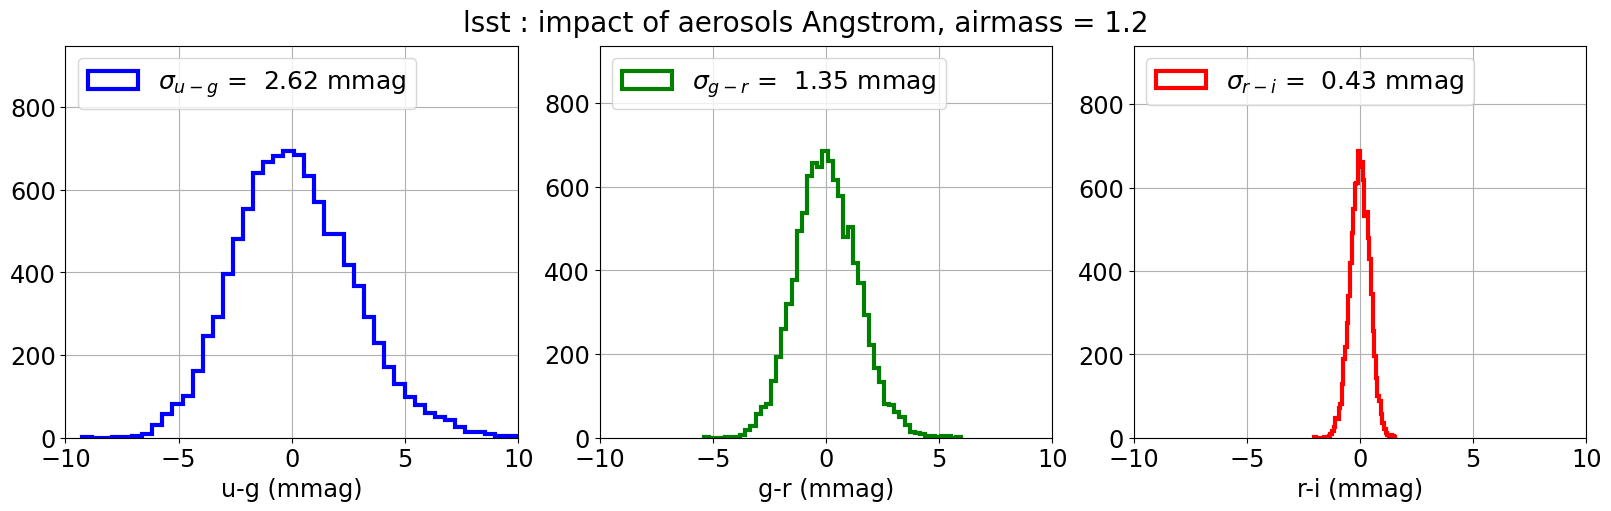

In [104]:
fig,axs = plt.subplots(1,3,figsize=(16,5),layout="constrained")

std1 = df["d_U-G"].agg(["std"])["std"]
txt1 = "$\sigma_{u-g}$ = " +f" {std1:.2f} mmag"
std2 = df["d_G-R"].agg(["std"])["std"]
txt2 = "$\sigma_{g-r}$ = " +f" {std2:.2f} mmag"
std3 = df["d_R-I"].agg(["std"])["std"]
txt3 = "$\sigma_{r-i}$ = " +f" {std3:.2f} mmag"

ax1,ax2,ax3 = axs.flatten()
df["d_U-G"].hist(ax=ax1,bins=50,histtype="step",lw=5,color="b",label=txt1,linewidth=3)
df["d_G-R"].hist(ax=ax2,bins=50,histtype="step",lw=5,color="g",label=txt2,linewidth=3)
df["d_R-I"].hist(ax=ax3,bins=50,histtype="step",lw=5,color="r",label=txt3,linewidth=3)
ax1.legend(loc="upper left"); ax2.legend(loc="upper left") ; ax3.legend(loc="upper left")
ax1.set_xlabel("u-g (mmag)") ;  ax2.set_xlabel("g-r (mmag)") ; ax3.set_xlabel("r-i (mmag)") 
ax1.set_ylim(0.,1.3*ax1.get_ylim()[1]), ax2.set_ylim(0.,1.3*ax2.get_ylim()[1]); ax3.set_ylim(0.,1.3*ax3.get_ylim()[1])
ax1.set_xlim(-10,10.); ax2.set_xlim(-10,10.); ax3.set_xlim(-10,10.); 
plt.suptitle(f"{obs} : impact of aerosols Angstrom, airmass = {am0}",fontsize=20)
plt.show()

## Plot transparencies

In [105]:
all_percentiles = np.arange(0.01,1.0,0.01)
Npercentiles = len(all_percentiles)
xquantiles_pwv = [ np.quantile(data_sim_pwv, q) for q in all_percentiles]
xquantiles_o3 = [ np.quantile(data_sim_o3, q) for q in all_percentiles]
xquantiles_vaod = [ np.quantile(data_sim_vaod, q) for q in all_percentiles]
xquantiles_angstrom = [ np.quantile(data_sim_angstrom, q) for q in all_percentiles]

### Make colormaps

In [106]:
cmap = mpl.colormaps['Blues']
cmap_invert = mpl.colormaps['Blues_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_blues = np.vstack((colors1,colors2))
the_deep_color_blue = colors2[0]
#the_deep_color = colors1[-1]

In [107]:
cmap_deepcolor = mcolors.ListedColormap(the_deep_color_blue)

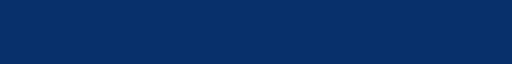

In [108]:
cmap_deepcolor

In [109]:
cmap = mpl.colormaps['Reds']
cmap_invert = mpl.colormaps['Reds_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_reds = np.vstack((colors1,colors2))

In [110]:
cmap = mpl.colormaps['Greens']
cmap_invert = mpl.colormaps['Greens_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_greens = np.vstack((colors1,colors2))

In [111]:
cmap = mpl.colormaps['Purples']
cmap_invert = mpl.colormaps['Purples_r']
colors1 = cmap(np.linspace(0, 1, Npercentiles//2))
colors2 = cmap_invert(np.linspace(0, 1, Npercentiles - Npercentiles//2))
all_colors_purples = np.vstack((colors1,colors2))

## Simulate transparencies

In [112]:
from getObsAtmo.getObsAtmo import ObsAtmo,validateObsName,Dict_Of_sitesPressures,getObsSiteDataFrame

In [113]:
emul =  ObsAtmo(obs_str= "LSST")
WL = emul.GetWL()

LSST site name validated as LSST observatory


### Transmission with PWV

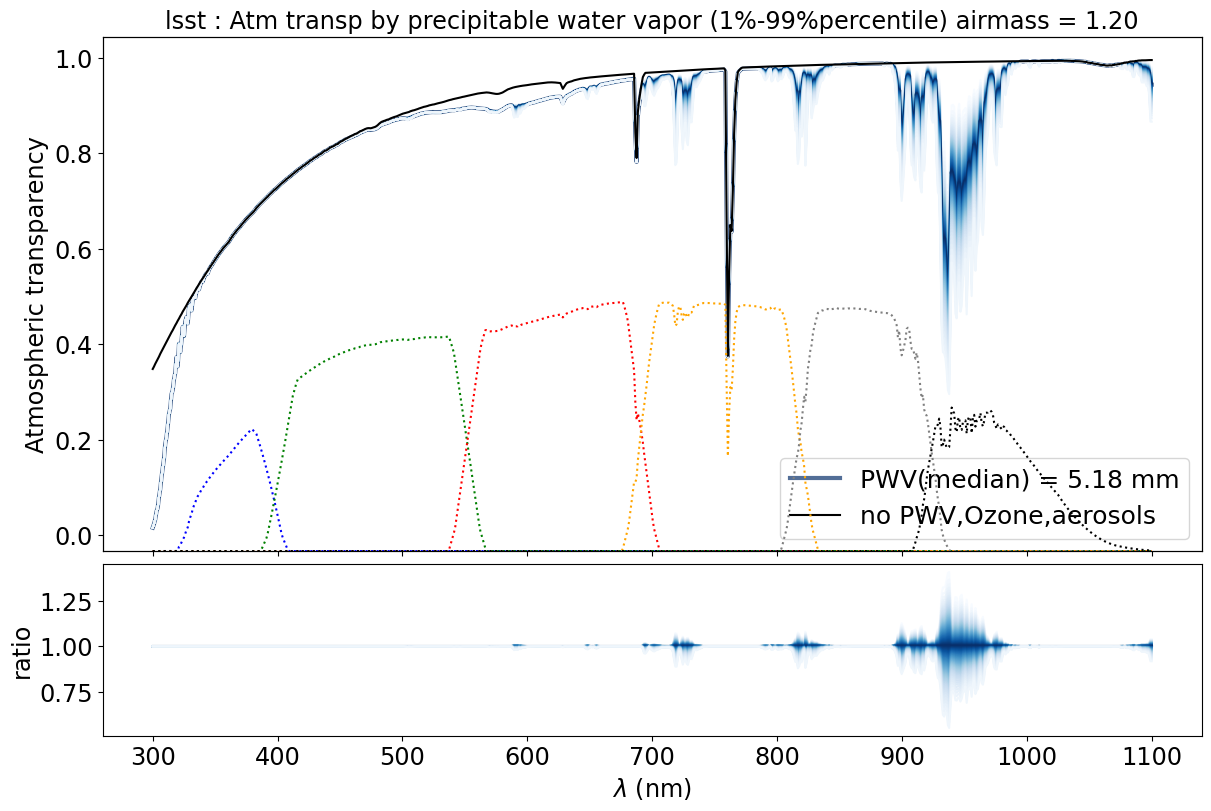

In [123]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.

fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_pwv ):
    pwv0 = quantile
    if pwv0<15.0:
        transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0)
        ax1.plot(WL,transm,color=all_colors_blues[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv0:.2f} mm"
        ax1.plot(WL,transm,color=all_colors_blues[idx],label=label,lw=3,alpha=0.7) 
        #ax1.plot(WL,transm,color=the_deep_color_blue ,label=label,lw=3) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_pwv):
    pwv0 = quantile
    if pwv0<15.0:
        transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0)
        ax2.plot(WL,transm/transm_median,color=all_colors_blues[idx]) 

   
transm = emul.GetAllTransparencies(WL,am0,0,0,0)
ax1.plot(WL,transm,color='k',label="no PWV,Ozone,aerosols") 
ax1.set_title(f"{obs} : Atm transp by precipitable water vapor (1%-99%percentile) airmass = {am0:.2f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("ratio")
ax1.set_ylabel("Atmospheric transparency")
ax1.legend()

# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)

plt.setp(ax1.get_xticklabels(), visible=False)

figname =f"{pathfigs}/{obs}_atmtransmpwv_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Transmission with Ozone

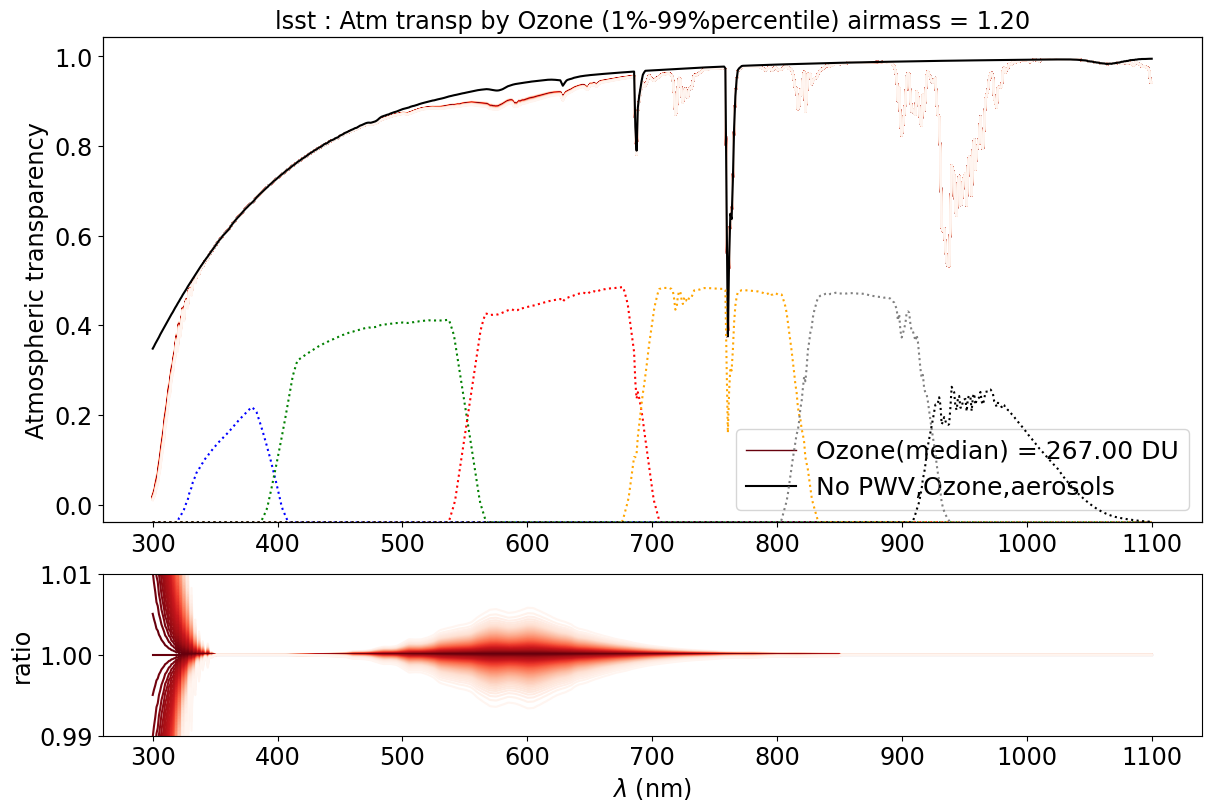

In [120]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.


fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz,0)
    ax1.plot(WL,transm,color=all_colors_reds[idx]) 
    if idx== Npercentiles//2:
        label = f"Ozone(median) = {oz0:.2f} DU"
        ax1.plot(WL,transm,color=all_colors_reds[idx],label=label,lw=1) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_o3 ):
    oz = quantile
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz)
    ax2.plot(WL,transm/transm_median,color=all_colors_reds[idx]) 


transm = emul.GetAllTransparencies(WL,am0,0,0)
ax1.plot(WL,transm,color='k',label="No PWV,Ozone,aerosols") 

ax1.set_title(f"{obs} : Atm transp by Ozone (1%-99%percentile) airmass = {am0:.2f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Atmospheric transparency")
ax2.set_ylim(0.99,1.01)
ax2.set_ylabel("ratio")
ax1.legend()


# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)


figname =f"{pathfigs}/{obs}_atmtransmozone_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Transmission with VAOD

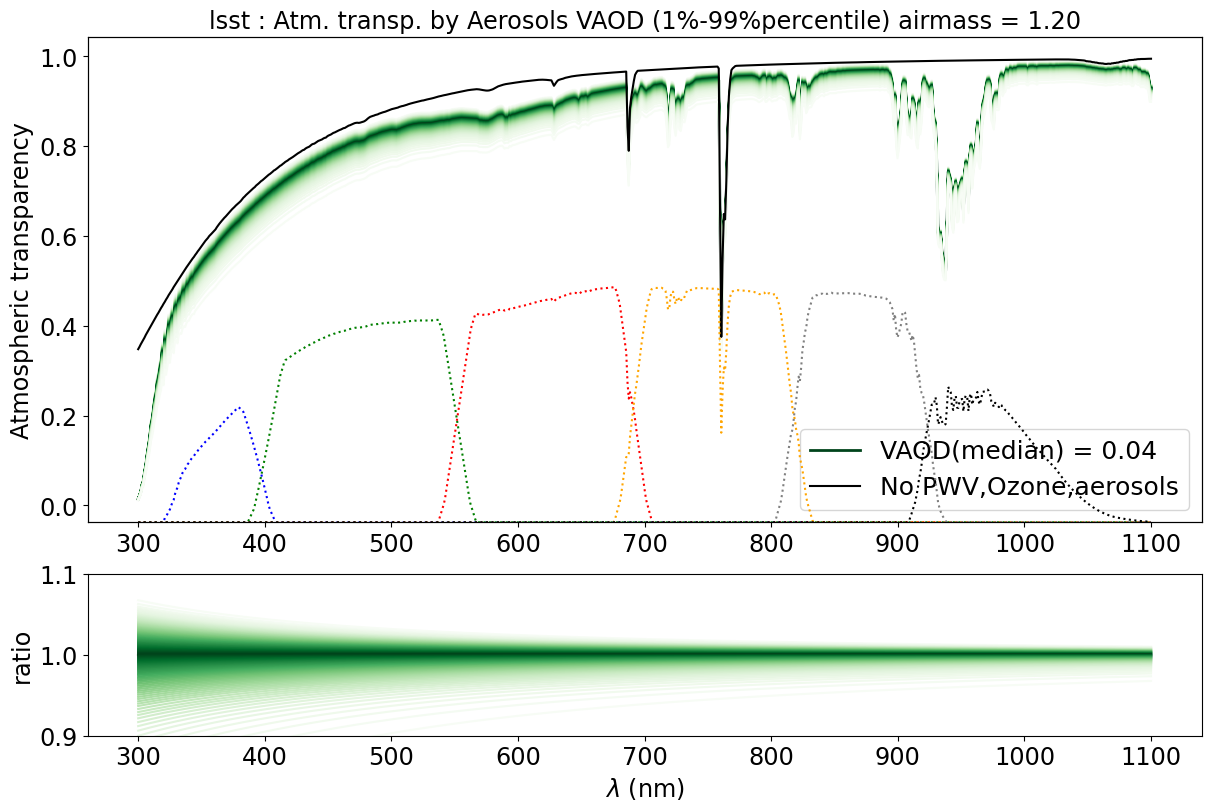

In [121]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
ang0 = 1.435


fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod,beta=ang0)
    ax1.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax1.plot(WL,transm,color=all_colors_greens[idx],label=label,lw=2)
        transm_median = transm
        
#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod,beta=ang0)
    ax2.plot(WL,transm/transm_median,color=all_colors_greens[idx]) 
    


transm = emul.GetAllTransparencies(WL,am0,0,0)
ax1.plot(WL,transm,color='k',label="No PWV,Ozone,aerosols") 

ax1.set_title(f"{obs} : Atm. transp. by Aerosols VAOD (1%-99%percentile) airmass = {am0:.2f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Atmospheric transparency")
ax1.legend()
ax2.set_ylabel("ratio")
ax2.set_ylim(0.9,1.1)

# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)

plt.setp(ax1.get_xticklabels(), visible=False)

figname =f"{pathfigs}/{obs}_atmtransmvaod_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Transmission with VAOD-Angstrom exponent

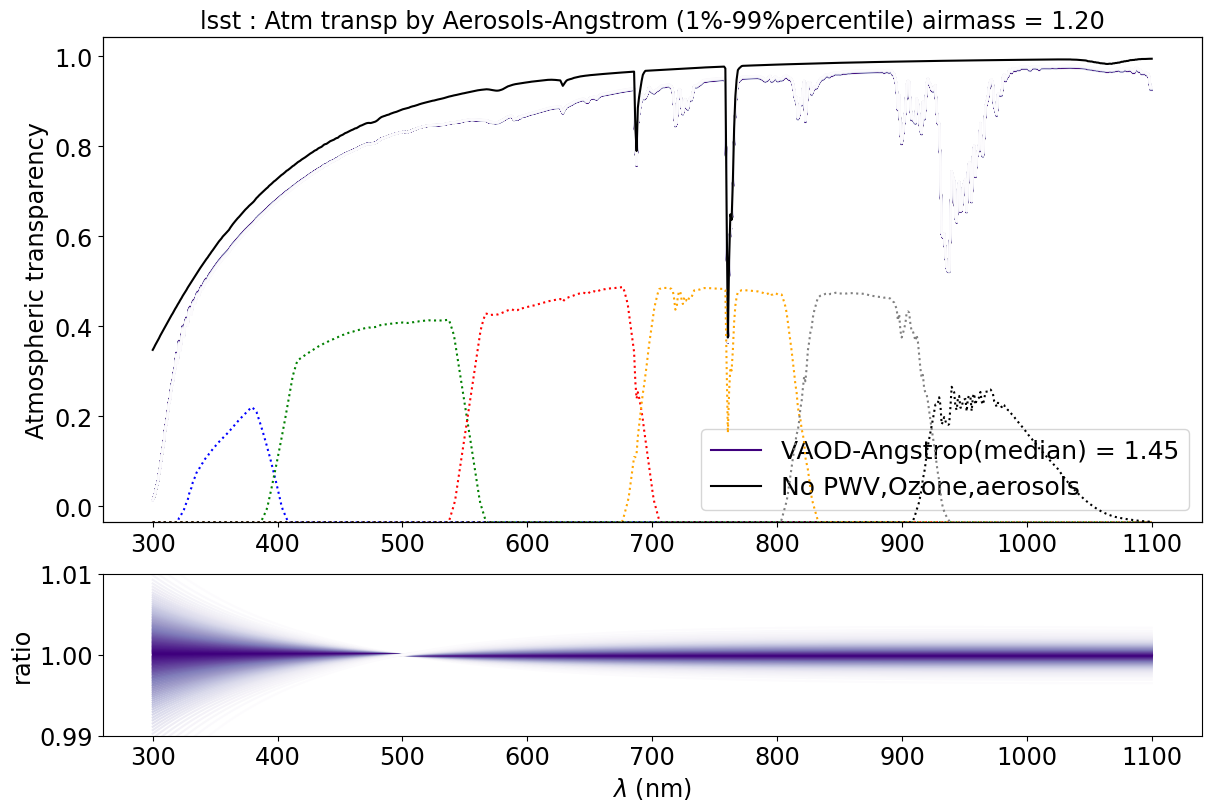

In [122]:
am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0= 0.04

fig = plt.figure(figsize=(12, 8),layout="constrained")
gs = fig.add_gridspec(2, 1  , height_ratios=(3 ,1),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.01, hspace=0.01)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

#atmospheric transmission
for idx,quantile in enumerate(xquantiles_angstrom ):
    ang = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang )
    ax1.plot(WL,transm,color=all_colors_purples[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD-Angstrop(median) = {ang:.2f}"
        ax1.plot(WL,transm,color=all_colors_purples[idx],label=label) 
        transm_median = transm

#atmospheric transmission ratio
for idx,quantile in enumerate(xquantiles_angstrom ):
    ang = quantile
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang )
    ax2.plot(WL,transm/transm_median,color=all_colors_purples[idx]) 

transm = emul.GetAllTransparencies(WL,am0,0,0)
ax1.plot(WL,transm,color='k',label="No PWV,Ozone,aerosols") 
ax1.set_title(f"{obs} : Atm transp by Aerosols-Angstrom (1%-99%percentile) airmass = {am0:.2f}")
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylim(0.99,1.01)
ax1.set_ylabel("Atmospheric transparency")
ax1.legend()
ax2.set_ylabel("ratio")



# band transmission    
ax1bis= ax1.twinx()
for index,f in enumerate(filter_tagnames):    
    ax1bis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
ax1bis.set_ylim(0.,1.)
ax1bis.axes.get_yaxis().set_visible(False)


plt.setp(ax1.get_xticklabels(), visible=False)

figname =f"{pathfigs}/{obs}_atmtransmangstrom_predmerra2"+figtype
fig.savefig(figname)

plt.show()

### Combined transmission without ratio

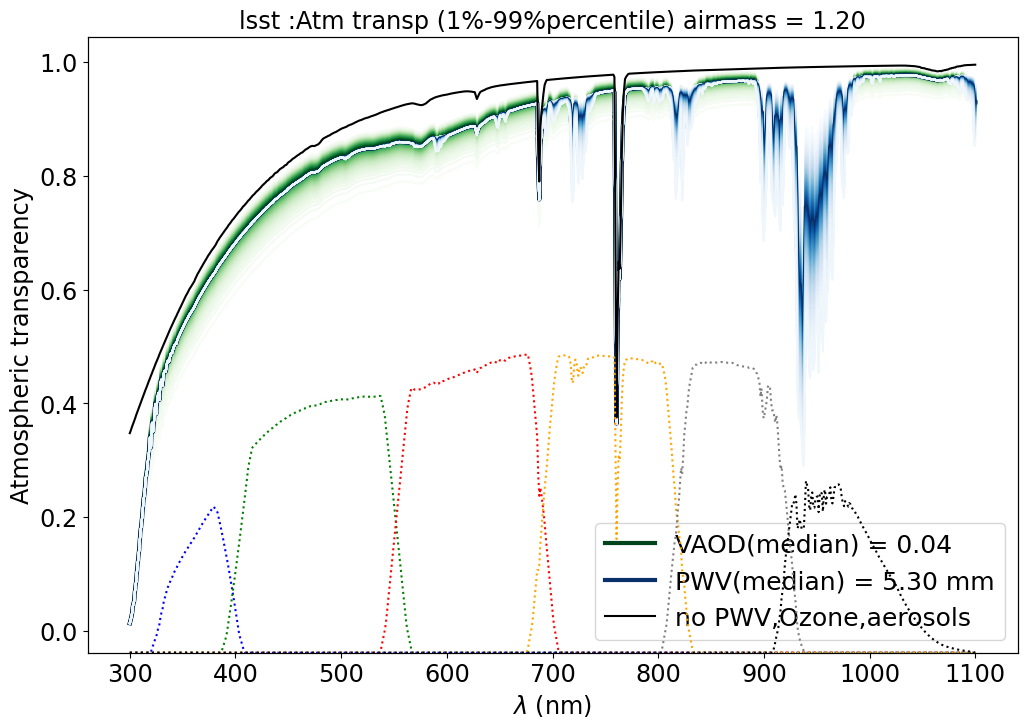

In [118]:
fig, ax = plt.subplots(1,1,figsize=(12,8))


am0 = 1.2
pwv0 = 5.3
oz0 = 267.
vaod0= 0.04
ang0 = 1.435


# Ozone
#for idx,quantile in enumerate(xquantiles_o3):
#    oz = quantile  
#    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz,vaod0,ang0)
#    ax.plot(WL,transm,color=all_colors_reds[idx]) 
#    if idx== Npercentiles//2:
#        label = f"Ozone(median) = {oz0:.2f} DU"
#        ax.plot(WL,transm,color=all_colors_reds[idx],label=label,lw=3) 


# Angstrom
#for idx,quantile in enumerate(xquantiles_angstrom):
#    ang = quantile   
#    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod0,beta=ang )
#    ax.plot(WL,transm,color=all_colors_purples[idx]) 
#    if idx== Npercentiles//2:
#        label = f"VAOD-Angstrop(median) = {ang:.2f}"
#        ax.plot(WL,transm,color=all_colors_purples[idx],label=label,lw=3) 

#atmospheric transmission

#VAOD
for idx,quantile in enumerate(xquantiles_vaod ):
    vaod = quantile
   
    transm = emul.GetAllTransparencies(WL,am0,pwv0,oz0,tau=vaod,beta=ang0)
    ax.plot(WL,transm,color=all_colors_greens[idx]) 
    if idx== Npercentiles//2:
        label = f"VAOD(median) = {vaod:.2f}"
        ax.plot(WL,transm,color=all_colors_greens[idx],label=label,lw=3) 

# PWV
for idx,quantile in enumerate(xquantiles_pwv):
    pwv = quantile
    if pwv<15.0:
        transm = emul.GetAllTransparencies(WL,am0,pwv,oz0,vaod0,ang0)
        ax.plot(WL,transm,color=all_colors_blues[idx]) 
    if idx== Npercentiles//2:
        label = f"PWV(median) = {pwv0:.2f} mm"
        ax.plot(WL,transm,color=all_colors_blues[idx],label=label,lw=3) 



        
transm = emul.GetAllTransparencies(WL,am0,0,0,0)
ax.plot(WL,transm,color='k',label="no PWV,Ozone,aerosols") 

ax.set_title(f"{obs} :Atm transp (1%-99%percentile) airmass = {am0:.2f}")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("Atmospheric transparency")
ax.legend()

# band transmission    
axbis= ax.twinx()
for index,f in enumerate(filter_tagnames):    
    axbis.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,':',color=filter_color[index]) 
axbis.set_ylim(0.,1.)
axbis.axes.get_yaxis().set_visible(False)


figname =f"{pathfigs}/{obs}_atmtransmpwvvaodcombined_predmerra2"+figtype
fig.savefig(figname)


plt.show()